This notebook recovers the result from this paper: [Entanglement Accelerates Quantum Simulation](https://www.nature.com/articles/s41567-025-02945-2).

Quantum entanglement is an essential feature of many-body systems that impacts both quantum information processing and fundamental physics. Classical simulation methods can efficiently simulate many-body states with low entanglement, but struggle as the degree of entanglement grows. 
This paper investigate the relationship between quantum entanglement and quantum simulation, and show that product formula approximations for simulating many-body systems can perform better for entangled systems.
This shows that entanglement is not only an obstacle to classical simulation, but also a feature that can accelerate quantum algorithms.

Notebook made by Jonah So (jonahso@ucsb.edu) and Jue Xu (xujue@connect.hku.hk)

In [ ]:
# Relevant imports

import cudaq
import cupy as cp
from cupyx.scipy.linalg import expm
import numpy as np
import time, sys
from cudaq import spin
from cudaq import State
import matplotlib.pyplot as plt
from typing import List

In [2]:
'''
Create initial state |1010...> 
''' 
@cudaq.kernel
def get_initial_state(n_spins: int):
    qubits = cudaq.qvector(n_spins)
    for i in range(0, n_spins, 2):
        x(qubits[i])

## Background

### Hamiltonian Preparation

We consider the
n-qubit one-dimensional quantum Ising spin model N with mixed fields (**QIMF**) used in the paper,
for which the entanglement grows rapidly.

The QIMF Hamiltonian is defined as the following:

$$
H \;=\;
h_x \sum_{j=1}^N X_j \;+\;
h_y \sum_{j=1}^N Y_j \;+\;
J \sum_{j=1}^{N-1} X_j X_{j+1}
$$

where $X_j, Y_j, Z_j$ are Pauli operators on qubit $j$ and $h_x,h_y,J$ are the coefficients of the interaction strength.

The following code creates the QIMF Hamiltonian.

In [3]:
def create_hamiltonian_qimf(n_spins: int, J: float, h_x: float, h_y: float):
    A = 0
    B = 0
    for j in range(n_spins - 1):
        A += J * spin.x(j) * spin.x(j + 1)

    for j in range(n_spins):
        A += h_x * spin.x(j)
        B += h_y * spin.y(j)

    return A, B, A+B

### First-Order Product Formula (PF1)

Given a Hamiltonian $H$ and evolution time $t$, the **ideal time evolution operator** is:
$
U(t) = e^{-i H t},
$
which is notoriously hard to simulate directly due to exponentially large space.

For local Hamiltonians, the Trotter formula, also known as the Product Formula (PF), 
is an algorithm to approximate the ideal evolution. 

Specifically, we can decompose the local Hamiltonian as:
$$
H = \sum_{l=1}^L H_l = \sum_{l=1}^L c_l P_l
$$
where: $c_l \in \mathbb{R}$ are the coefficients and $P_l$ are Pauli words (tensor products of Pauli matrices) with system-size independent weights.

For a short-time $\delta t$ evolution,
the **first-order Trotter approximation** (PF1) approximates the ideal evolution by sequentially applying each term:
$
\mathscr{U}(\delta t) \;\approx\; \overrightarrow{\prod_{l}} e^{-i H_l \, \delta t}
$
where each term evolution $e^{-i H_l \, \delta t}$ can be realized by local elementary quantum gates.

However, the Hamiltonan terms $H_l$ do not necessarily commute with each other.
So, the Trotter formula (PF1) would introduce the algorithmic error of order $\mathcal{O}(\delta t^2)$, called **Trotter error**. 

### Trotter Approximation (PF1) 

For the QIMF Hamiltonian, we can regroup the Hamiltonian terms into two groups
$$
A = h_x \sum_j X_j \;+\; J \sum_j X_j X_{j+1},
\qquad
B = h_y \sum_j Y_j,
$$
where every term in the same group commutes with each other.

So, the first-order Trotter step can be written as:
$$
\mathscr{U}_1(\delta t) \;\approx\; e^{-i A \delta t} \, e^{-i B \delta t},
$$
and the long-time $t$ evolution is approximated by repeating $\mathscr{U}_1(\delta t)$ for $r$ times as
$$
U(t):= e^{-i H t} \approx (\mathscr{U}_1(\delta t))^r
$$
where $t=r\cdot \delta t$ and $r$ is called the number of Trotter steps.

In [4]:
'''
The following kernel performs one trotter step for a Hamiltonian, split into two non-commuting parts.  
Each represented by: 
c_a, c_b: List[complex] 
    a set of coefficients corresponding to the Pauli terms 
words_a, words_b: List[complex]
    a list of Pauli words specifying the operators
'''
@cudaq.kernel
def trotter_step_pf1 (state: cudaq.State, dt: float, c_a: List[complex], 
                      c_b: List[complex], words_a: List[cudaq.pauli_word], words_b: List[cudaq.pauli_word]):
    qubits = cudaq.qvector(state)

    for i in range(len(c_a)):
        exp_pauli(-c_a[i].real * dt, qubits, words_a[i])

    for i in range(len(c_b)):
        exp_pauli(-c_b[i].real * dt, qubits, words_b[i])


In [5]:
'''
Here, we extract coefficients and words from Hamiltonian for decomposition.
'''
def extractCoefficients(hamiltonian: cudaq.SpinOperator):
    result = []
    for term in hamiltonian:
        result.append(term.evaluate_coefficient())
        # print(term.evaluate_coefficient)
    return result

def extractWords(hamiltonian: cudaq.SpinOperator):
    n_spins = hamiltonian.qubit_count
    result = []
    for term in hamiltonian:
        result.append(term.get_pauli_word(n_spins))
    return result

### Entanglement Measure

Given a pure state $|\psi\rangle$ of an $n$-qubit system, the reduced density matrix for a subset of qubits $A$ is

$$
\rho_A = \mathrm{Tr}_B \big( |\psi\rangle \langle \psi | \big),
$$

where $B$ is the set of qubits traced out.

We can quantify the state entanglement with the subsystem by calculating **von Neumann entropy** of $\rho_A$:

$$S(\rho_A) = - \text {Tr} [\rho_A \log \rho_A] = - \sum_i \lambda_i \log_2 \lambda_i$$

where $\lambda_i$ are the eigenvalues of the reduced density matrix.

In [6]:
'''
The following function computes the reduced density matrix for a pure state of an n-qubit system. 
    psi: cp.ndarray 
        The full statevector of the system 
    keep: List[int] 
        The list of qubit indices to "keep" (subsystem A). The rest of the qubits will be traced out (sybsystem B). 
    n_qubits: int 
        The number of qubits 
''' 
def partial_trace (psi: cp.ndarray, keep: List[int], n_qubits: int) -> cp.ndarray:

    psi = psi / cp.linalg.norm(psi)

    traced_out = [i for i in range(n_qubits) if i not in keep]
    dim_keep = 2 ** len(keep)
    dim_traced = 2 ** len(traced_out)
    
    psi = psi.reshape([2] * n_qubits)
    perm = keep + traced_out
    psi = psi.transpose(perm)
    psi = psi.reshape(dim_keep, dim_traced)

    rho_A = psi @ psi.conj().T
    return rho_A

In [7]:
'''
The following function calculates the entropy of a given density matrix: 
    rho: cp.ndarray
''' 
def entropy(rho: cp.ndarray) -> float:
    eigvals = cp.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > 0]
    entropy = -cp.sum(eigvals * cp.log2(eigvals))
    return entropy.get() 

In [8]:
'''
This function constructs the exact unitary time-evolution operator U = exp(-i*H*dt), given
    H: cudaq.SpinOperator 
        The Hamiltonian operator 
    dt: float
'''
def ideal_U (H: cudaq.SpinOperator, dt: float) -> cp.ndarray:
    Hm = cp.asarray(H.to_matrix())
    return expm(-1j * Hm * dt)

'''
The following function apply the exact unitary time-evolution operator U to the current state. 
    U: cp.ndarray
        Unitary time-evolution operator
    state: cp.ndarray 
        Current quantum state 
''' 
def ideal_next_state(U: cp.ndarray, state: cp.ndarray) -> cp.ndarray:
    # psi = cp.asarray(state, dtype=cp.complex128)
    return U @ state

### Trotter error 
The one-segment Trotter error is calculated by 
$$
∥ (U_0(\delta t) − \mathscr{U}_p(\delta t))|\psi (t)⟩∥,
$$ 
where $|\psi (t)⟩ = e^{-iHt} |\psi (0)⟩ $ is the ideal state at time t. 

In [9]:
def trotter_error(psi_ideal, psi_trot):
    return ((cp.linalg.norm(psi_ideal - psi_trot)))

Two evolutions are simulated by the following code block:

- Ideal (exact) evolution using unitary $ U = e^{-iH\delta t} $

- First-order (PF1) Trotterization using separate A and B terms $\mathscr{U}_1(\delta t) \;\approx\; e^{-i A \delta t} \, e^{-i B \delta t}$

In [10]:
def ideal_simulation (n_spins: int, initial_state: cudaq.State, r: int, h_x_val: float, h_y_val: float, J_val: float):   
    ideal_state = initial_state
    t_state = initial_state

    out_list_ideal = []
    out_list_trotter = []

    time_list = []

    # dt is set as 0.1, as indicated in the paper 
    dt = 0.1
    
    # prepare hamiltonian for evolution 
    A, B, H = create_hamiltonian_qimf(n_spins, J=J_val, h_x=h_x_val, h_y=h_y_val)
    c_a = extractCoefficients(A)
    c_b = extractCoefficients(B)
    words_a = extractWords(A)
    words_b = extractWords(B)
    
    start_time = time.time()

    U = ideal_U(H, dt) 
    psi_ideal = cp.asarray(ideal_state, dtype=cp.complex128) 
    
    for step in range(1, r + 1):
        psi_ideal = ideal_next_state(U, psi_ideal)
        t_state = cudaq.get_state(trotter_step_pf1, t_state, dt, c_a, c_b, words_a, words_b)
        
        psi_t = cp.asarray(t_state, dtype=cp.complex128) 

        out_list_ideal.append(psi_ideal)
        out_list_trotter.append(psi_t)
        time_list.append(dt * step)
        
        # Compare trotter at one step 
        psi_ideal = psi_t 
    
    total_time = time.time() - start_time
    print(f"Simulation done in {total_time:.2f} seconds")

    return out_list_ideal, out_list_trotter 

## Main code

For the QIMF Hamiltonian of $n=12$ qubits,
we simulate the entanglement entropy of different subsystem sizes and Trotter error in one segment using the PF1 ($t=10$, $r=100$).

In [ ]:
n = 12 # system size, num of qubits
r = 100 # num of trotter steps

# initial state 
initial_state = cudaq.get_state(get_initial_state, n)

# field strength and coupling strength 
h_x_val, h_y_val, J_val = 0.8090, 0.9045, 1

# the simulation returns a collection of states from computing ideal and trotter evolutions 
ideal, trotter = ideal_simulation(n, initial_state, r, h_x_val, h_y_val, J_val)

tro_error = [] 
# compute trotter error, by looking at the two states at each step 
for i in range(r): 
    tro = trotter_error(ideal[i], trotter[i])
    tro_error.append(tro.get()) 

# calculate entanglement entropy for ideal evolutions at each step, resepctively 
entropy_list = [] 
for i in range (r): 
    rdm1 = partial_trace(ideal[i], list(range(1)), n_qubits=n)
    rdm2 = partial_trace(ideal[i], list(range(2)), n_qubits=n)
    rdm3 = partial_trace(ideal[i], list(range(3)), n_qubits=n)
    rdm4 = partial_trace(ideal[i], list(range(4)), n_qubits=n)

    temp = [entropy(rdm1), entropy(rdm2), entropy(rdm3), entropy(rdm4)]
    # print(temp)
    entropy_list.append(temp) 

Simulation done in 3.61 seconds


## Visualization of Entanglement and Trotter error

We recovered the Fig.1a in [Entanglement Accelerates Quantum Simulation](https://www.nature.com/articles/s41567-025-02945-2).
The entanglement entropies of various subsystems all increase with time to the corresponding maximal value, as indicated by the right y axis. As the entanglement entropy increases,
the empirical Trotter error decreases and converges to the average-case error.

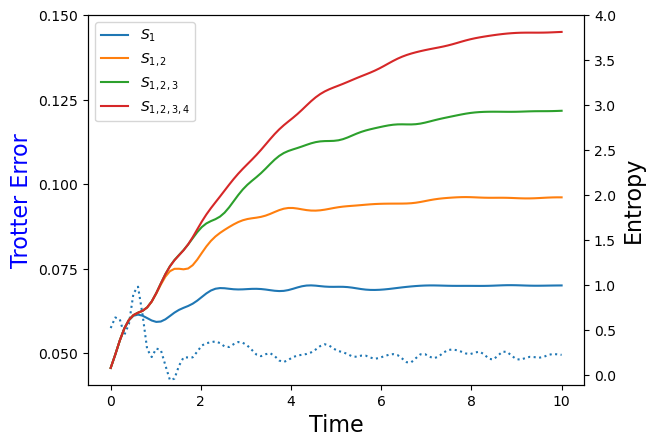

In [15]:
t_list = np.linspace(0, 10, 100)
steps = len(entropy_list)
times = np.linspace(0, 10, 100)

entropy_values_1 = [entropy[0] for entropy in entropy_list]
entropy_values_2 = [entropy[1] for entropy in entropy_list]
entropy_values_3 = [entropy[2] for entropy in entropy_list]
entropy_values_4 = [entropy[3] for entropy in entropy_list]

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True)
ax2 = axes.twinx() 
# Create the plot

ax2.plot(times, entropy_values_1, label= r'$S_{1}$')
ax2.plot(times, entropy_values_2, label= r'$S_{1,2}$')
ax2.plot(times, entropy_values_3, label= r'$S_{1,2,3}$')
ax2.plot(times, entropy_values_4, label= r'$S_{1,2,3,4}$') 

axes.plot(times, tro_error, linestyle=":") 
y_ticks = [0.05, 0.075, 0.1, 0.125, 0.15] 
axes.set_yticks(y_ticks) 
axes.set_ylabel("Trotter Error", color='b', fontsize=16) 
axes.set_xlabel("Time", fontsize=16)

ax2.set_ylabel("Entropy", fontsize=16)

ax2.legend()

## Relevant references
- [Entanglement accelerates quantum simulation](https://arxiv.org/abs/2406.02379)
- [Spin-Hamiltonian Simulation Using CUDA-Q](https://nvidia.github.io/cuda-quantum/latest/applications/python/hamiltonian_simulation.html)

In [ ]:
!python --version

Python 3.13.5


In [3]:
print(cudaq.__version__)

CUDA-Q Version 0.12.0 (https://github.com/NVIDIA/cuda-quantum 6adf92bcda4df7465e4fe82f1c8f782ae69d8bd2)
